# The energetic conditions of ridge propagation
If a ridge is to propagate, then the work available to drive propagation must necessarily exceed the work dissipated by the existing transform, $\Phi$.

Also necessary, the strain energy released by the growth of one ridge axis must be greater than the energy absorbed by the dying ridge. Within a fracture mechanics framework, this is equivalent to a stress intensity factor driving the growing ridge, $K_d$, exceeding the stress intensity factor resisting the growth, $K_r$.

In [1]:
from subprocess import call
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

In [2]:
def compute_transform_energy(age_offset,rate,flags={}):
    outfile = open('out.temp','w')
    runcmd = 'transform_energy' + ' ' + str(age_offset) + ' ' + str(rate) + ' '
    for flag, val in flags.items():
        runcmd = runcmd + str(flag) + ' ' + str(val) + ' '
    call(runcmd,shell=True,stdout=outfile)
    total_work = np.loadtxt('out.temp')
    return total_work

In [22]:
def plot_transform_energy(rates,offsets,phi,mode=1):
    if mode == 1:
        fig_a, axes = plt.subplots(nrows=1,ncols=2,sharex='all',figsize=(12.0, 3.0))
        j = 0
        for rate in rates:
            label_str = str(rate*100) + 'cm/yr'
            axes[0].plot(offsets,phi[j,:],label=label_str)
            axes[1].semilogy(offsets,phi[j,:])
            
            j += 1

        axes[0].set_xlabel('Age Offset (Myr)')
        axes[0].set_ylabel('Work (W)')
        axes[0].legend()
        axes[1].set_xlabel('Age Offset (Myr)')
        axes[1].set_ylabel('Work (W)')
            
    elif mode == 2:
        fig_a, axes = plt.subplots(nrows=1,ncols=m,sharey='all',sharex='all',figsize=(12.0, 3.0))
        j = 0
        for rate in rates:
            axes[j].plot(offsets,phi[j,:])
            axes[j].set_title(str(rate*100) + ' cm/yr half rate')
            if j == 0:
                axes[j].set_xlabel('Age Offset (Myr)')
                axes[j].set_ylabel('Work (W)')
            j += 1

## Estimating the work done at a transform zone (plate cooling model)
We can estimate the work done at a transform, $\Phi$, as the integral of $2\tau U$ over the transform zone, where $U$ is the half spreading rate and $\tau$ is the yield stress. We use a yield strength envelope with a realistic thermal model to estimate the work done at the transform. We need to consider that for a typical transform fault, the transform zone is significantly damaged and the yield stress is lower than that of the lithosphere generally. So, we need to keep in mind that this is likely an overestimate. However, since we're concerned not with well-developed transform faults but with the broader zones of deformation, the estimate might not be so bad.

We will estimate the work done for a given spreading rate while varying the length of the transform offset or the age difference at the offset. Let's do this for three different half spreading rates: 10 cm/yr, 20 cm/yr, and 40 cm/yr

In [23]:
rates = [0.01,0.02,0.04]
offsets = [0.1,0.3,0.5,1.0,1.5,2.0,2.5,3.0]
m = len(rates)
n = len(offsets)
phi_plate = np.zeros((m,n))

In [24]:
j = 0
for rate in rates:
    i = 0
    for offset in offsets:
        phi_plate[j,i] = compute_transform_energy(offset,rate)
        i += 1
    j += 1

Now let's visualize this...

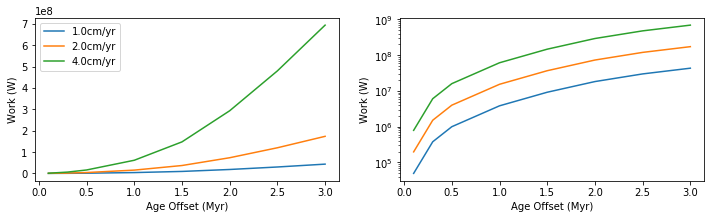

In [32]:
plot_transform_energy(rates,offsets,phi_plate)
plt.savefig('plate-strain-energy.pdf', bbox_inches='tight')

### An analytical solution
We might compare our results to an analytical solution to verify/qualify our approach. An analytical solution to can be found in Phipps Morgan and Parmentier (1985)

\begin{equation}
\Phi = \frac{\xi\rho g A^2 L^2}{4} + \frac{2AL\left(UL\right)^{1/2}}{3}\left(\tau_0 + \xi\rho gB\right) + BLU\left(\tau_0 + \frac{\xi\rho gB}{2}\right)
\end{equation}

We'll try and do the same style of loop over spreading rates and age offsets

In [26]:
def compute_transform_analytical(rate,length,A,B,tau_0,xi):
    g = 9.8 # acc gravity
    rho = 2900 # density, fixed
    T1 = xi*rho*g*(A**2)*(L**2)/4
    T2 = (2*A*L*sqrt(U*L)/3)*(tau_0 + xi*rho*g*B)
    T3 = B*L*U*(tau_0 + (xi*rho*g*B/2))
    phi = T1 + T2 + T3
    return phi

In [27]:
A = 10000 / sqrt(1e6) / sqrt(365.25) / sqrt(24) / sqrt(60) / sqrt(60) # very annoying units...
B = 10000
xi = 0.6
tau_0 = 0

rates = [0.01,0.02,0.04]
offsets = [0.1,0.3,0.5,1.0,1.5,2.0,2.5,3.0]
m = len(rates)
n = len(offsets)
phi_anal = np.zeros((m,n))

In [28]:
j = 0
for rate in rates:
    i = 0;
    U = rate/365.25/24/60/60
    for offset in offsets:
        L = offset*1e6*rate # convert age offset to a distance
        phi_anal[j,i] = compute_transform_analytical(U,L,A,B,tau_0,xi)
        i += 1
    j += 1

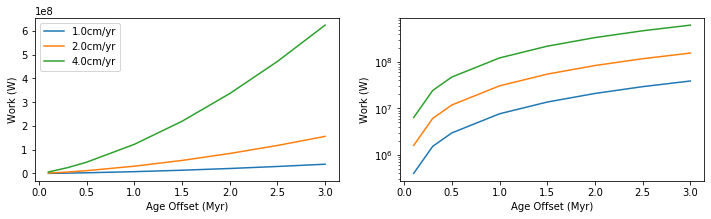

In [29]:
plot_transform_energy(rates,offsets,phi_anal)
plt.savefig('analytical-strain-energy.pdf', bbox_inches='tight')

## Alternative cooling models
In the 'src/thermal' and 'src/ocean_litho_yse' notebooks, we looked at a few different lithospheric cooling models and their effects on yield strength. We saw that there wasn't a particularly big difference. Will there be an appreciable difference here if we use the Sleep (1975) cooling model? What about if we then added heat sinks?

In [30]:
mod_flags = {
    'tesw': 1,
    'hssw': 0
}
rates = [0.01,0.02,0.04]
offsets = [0.1,0.3,0.5,1.0,1.5,2.0,2.5,3.0]
m = len(rates)
n = len(offsets)
phi_sleep = np.zeros((m,n))

In [31]:
j = 0
for rate in rates:
    i = 0
    for offset in offsets:
        phi_sleep[j,i] = compute_transform_energy(offset,rate,mod_flags)
        i += 1
    j += 1

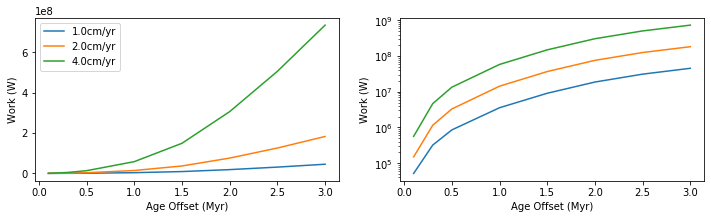

In [33]:
plot_transform_energy(rates,offsets,phi_sleep)
plt.savefig('sleep-strain-energy.pdf', bbox_inches='tight')

### Let's compare the three model results

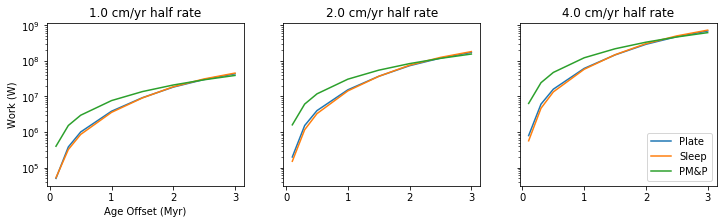

In [36]:
fig_a, axes = plt.subplots(nrows=1,ncols=m,sharey='all',sharex='all',figsize=(12.0, 3.0))
j = 0
for rate in rates:
    axes[j].semilogy(offsets,phi_plate[j,:],label="Plate")
    axes[j].semilogy(offsets,phi_sleep[j,:],label="Sleep")
    axes[j].semilogy(offsets,phi_anal[j,:],label="PM&P")
    axes[j].set_title(str(rate*100) + ' cm/yr half rate')
    if j == 0:
        axes[j].set_xlabel('Age Offset (Myr)')
        axes[j].set_ylabel('Work (W)')
    elif j == m-1:
        axes[j].legend()
    j += 1
    
plt.savefig('compare-3-strain-energy.pdf', bbox_inches='tight')

Basically, what this looks like is the analytical solution, since it doesn't take into account the cooling directly, misses some of the early weakness of the plate and overestimates the strength relative to the YSE model. But there's something curious here... Plotting age offset against the work yields similar looking curves for varying spreading rates, just shifting the curve upwards in magnitude with increasing spreading rate. However, what will it look like if we plot distance offset instead of age offset. For a 1 cm/yr spreading rate, a 3 Myr age offset represents 30 km distance offset. For a 4 cm/yr rate, the same distance offset is a 0.75 Myr age offset. So, we're approaching the conclusion that the age offset is not what matters but the distance

Let's do this again, but we'll vary the distance offset instead of the age. We'll do this for the plate cooling model first.

In [37]:
rates = [0.01,0.02,0.04,0.08]
dist_offsets = [2.5,5,7.5,10,15,20,25,30] # in km
m = len(rates)
n = len(dist_offsets)

In [38]:
phi_plate = np.zeros((m,n))
j = 0
for rate in rates:
    i = 0
    for d_offset in dist_offsets:
        # convert the dist_offset to an age offset in Myr
        offset = d_offset*1000/rate/1e6
        phi_plate[j,i] = compute_transform_energy(offset,rate)
        i += 1
    j += 1

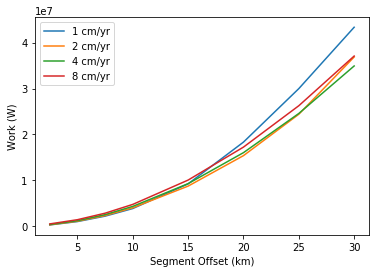

In [47]:
fig_a, axes = plt.subplots()

axes.plot(dist_offsets,phi_plate[0,:],label="1 cm/yr")
axes.plot(dist_offsets,phi_plate[1,:],label="2 cm/yr")
axes.plot(dist_offsets,phi_plate[2,:],label="4 cm/yr")
axes.plot(dist_offsets,phi_plate[3,:],label="8 cm/yr")
    
axes.set_xlabel('Segment Offset (km)')
axes.set_ylabel('Work (W)')
axes.legend()

plt.savefig('dist-offset-strain-energy.pdf', bbox_inches='tight')

Let's look at the Sleep model as well, where horizontal convection is included.

In [41]:
phi_sleep = np.zeros((m,n))
mod_flags = {
    'tesw': 1,
    'hssw': 0
}
j = 0
for rate in rates:
    i = 0
    for d_offset in dist_offsets:
        # convert the dist_offset to an age offset in Myr
        offset = d_offset*1000/rate/1e6
        phi_sleep[j,i] = compute_transform_energy(offset,rate,mod_flags)
        i += 1
    j += 1

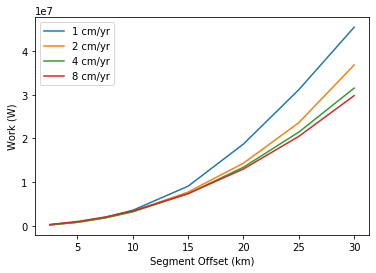

In [46]:
fig_a, axes = plt.subplots()

axes.plot(dist_offsets,phi_sleep[0,:],label="1 cm/yr")
axes.plot(dist_offsets,phi_sleep[1,:],label="2 cm/yr")
axes.plot(dist_offsets,phi_sleep[2,:],label="4 cm/yr")
axes.plot(dist_offsets,phi_sleep[3,:],label="8 cm/yr")
    
axes.set_xlabel('Segment Offset (km)')
axes.set_ylabel('Work (W)')
axes.legend()

plt.savefig('sleep-dist-offset-strain-energy.pdf', bbox_inches='tight')

So, indeed, in terms of the work dissipated at a transform, it would appear that age offset is not as important as the distance offset. Rather than speaking of an age limit, it's more like a transform offset length limit, regardless of spreading rate.

Adding in heat sinks is sort of problematic, because we would need to calibrate a heat sink distribution for each spreading rate. Let's just show the results a 2 cm/yr

In [43]:
phi_sinks = np.zeros((1,n))
mod_flags = {
    'tesw': 1,
    'hssw': 1
}
i = 0
for d_offset in dist_offsets:
    # convert the dist_offset to an age offset in Myr
    offset = d_offset*1000/rate/1e6
    phi_sinks[0,i] = compute_transform_energy(offset,rate,mod_flags)
    i += 1


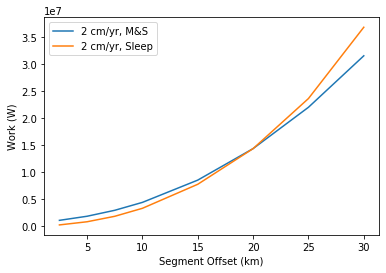

In [45]:
fig_a, axes = plt.subplots()

axes.plot(dist_offsets,phi_sinks[0,:],label="2 cm/yr, M&S")
axes.plot(dist_offsets,phi_sleep[1,:],label="2 cm/yr, Sleep")

axes.set_xlabel('Segment Offset (km)')
axes.set_ylabel('Work (W)')
axes.legend()

plt.savefig('sleep-sinks-strain-energy.pdf', bbox_inches='tight')